## Occlusion Experiments for object segmentation

This notebook tries to replicate the method and results of occlusion experiments conducted by M. Zeiler et al in their paper <em>"Visualising and understanding convolutional neural networks".</em> 

In this paper, the authors zero out parts of the unput image, feed it into a trained ConvNet for detection and monitor the output of the classifier. This leads to the generation of a heat-map whose values are a function of the classifier output when those parts were occluded in the original input image. 


In [1]:
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib.image as mpimage
from scipy.misc import imresize, imsave

from copy import deepcopy

In [2]:
import tensorflow.keras as keras

from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import optimizers
from keras import losses
from keras.callbacks import EarlyStopping
from keras import backend as K
from keras.models import load_model

Using TensorFlow backend.


In [3]:
import pickle

In [4]:
import tensorflow as tf

print(tf.__version__)

1.14.0


In [5]:
tipo = 3    #change type of image


# ========== EXTRACCIÓN DE DATOS ==============
archivo = open('./dataset/HiTS2013_100k_samples(4_channels)_images_labels.pkl',"rb")
example_dict= pickle.load(archivo)
print('Dimension of labels: N=',example_dict['labels'].shape[0])
print('Dimension of images:',example_dict['images'].shape)

L=example_dict['labels'].shape[0] #numero total de imagenes

Dimension of labels: N= 100000
Dimension of images: (100000, 21, 21, 4)


In [6]:
percentage_train=1   #how much do you want to test?

percentage= int(percentage_train*L)
xx = example_dict['images'][:, :, :, tipo]
yy= example_dict['labels']
print('Dimension of images to train:',xx[:percentage].shape)
print('Dimension of images to test:',xx[percentage:].shape)
print('Number of images to train: ', yy[:percentage].shape[0])
print('Number of images to test: ',yy[percentage:].shape[0])

#database to train
x_train=xx[:percentage]
y_train=yy[:percentage]

#database to test
x_test=xx[percentage:]
y_test=yy[percentage:]

#input shape para las redes convolucionales
input_shape1=x_test.shape[1]
input_shape2=x_test.shape[2]
print('\n\ninput_shape (2D): ' , input_shape1, 'x', input_shape2)

input_shape = (input_shape1, input_shape2, 1)
print('\n\ninput_shape (3D): ' , input_shape)

Dimension of images to train: (100000, 21, 21)
Dimension of images to test: (0, 21, 21)
Number of images to train:  100000
Number of images to test:  0


input_shape (2D):  21 x 21


input_shape (3D):  (21, 21, 1)


In [7]:
# Reshape the images.
r_x_train= np.expand_dims(x_train, axis=3)
r_x_test = np.expand_dims(x_test, axis=3)

print('r_x_train', r_x_train.shape)
print('r_x_test', r_x_test.shape)

r_x_train (100000, 21, 21, 1)
r_x_test (0, 21, 21, 1)


In [8]:
## Some useful functions

def to_3_axis(im_2d):
    im_3d = np.expand_dims(im_2d, axis=3)
    return im_3d

def to_4_axis(im_3d):
    im_4d = np.expand_dims(im_3d, axis=0)
    return im_4d    

def d2_to_d4(d2):
    d3=np.expand_dims(d2, axis=0)
    d4=np.expand_dims(d3, axis=-1)
    return d4


In [9]:
#normalization
def normalize(processed):
    ####### calculate global mean and standard deviation
    mean, std = processed.mean(), processed.std()
    #print('Mean: %.3f, Standard Deviation: %.3f' % (mean, std))
    ####### global standardization of pixels
    processed = (processed - mean) / std
    ####### clip pixel values to [-1,1]
    processed = np.clip(processed, -1.0, 1.0)
    ####### shift from [-1,1] to [0,1] with 0.5 mean
    processed = (processed + 1.0) / 2.0
    #print('after normalization')
    #print('Valor máximo :', processed.max())
    #print('Valor mínimo :', processed.min())
    return processed

### Occlusion Generator class

In [10]:
class OcclusionGenerator(object):
     
    def __init__(self, img, boxsize=10, step=10, prepocess=True):
        ''' Initializations '''
        self.img = img
        self.boxsize = boxsize
        self.step = step 
        self.i = 0
        self.j = 0
    

    def flow(self):
        ''' Return a single occluded image and its location '''
        if self.i + self.boxsize > self.img.shape[0]:
            return None, None, None
        
        #print('test shape', self.img.shape)
        
        retImg = np.copy(self.img)
        retImg[self.i:self.i+self.boxsize, self.j:self.j+self.boxsize] = 0.0 

        old_i = deepcopy(self.i) 
        old_j = deepcopy(self.j)
        
        # update indices
        self.j = self.j + self.step
        if self.j+self.boxsize>self.img.shape[1]: #reached end
            self.j = 0 # reset j
            self.i = self.i + self.step # go to next row
        
        return retImg, old_i, old_j

    def gen_minibatch(self, batchsize=10):
        ''' Returns a minibatch of images of size <=batchsize '''
        
        # list of occluded images
        occ_imlist = []
        locations = []
        for i in range(batchsize):
            occimg, i, j = self.flow()
            if occimg is not None:
                occ_imlist.append(occimg)
                locations.append([i,j])

        if len(occ_imlist)==0: # no data
            return None,None
        else:
            # convert list to numpy array
            
            return normalize(np.array(occ_imlist)), locations 


In [11]:
#preprocess to 2D and gets copy

def preprocessar(ximg):
    #image of (21,21)
    x = np.zeros((21, 21))
    print(ximg.shape)
    rimg= np.stack((ximg,)*3, axis=-1)
    x[:,:]= ximg[:,:] 
    print('---->', x.shape)

    return x

#preprocess 3D to 2D

def preprocessar_2d(ximg):

    print(ximg.shape)
    x= np.squeeze(ximg, axis=2)  
    print('---->', x.shape)

    
    return x

(21, 21)
----> (21, 21)


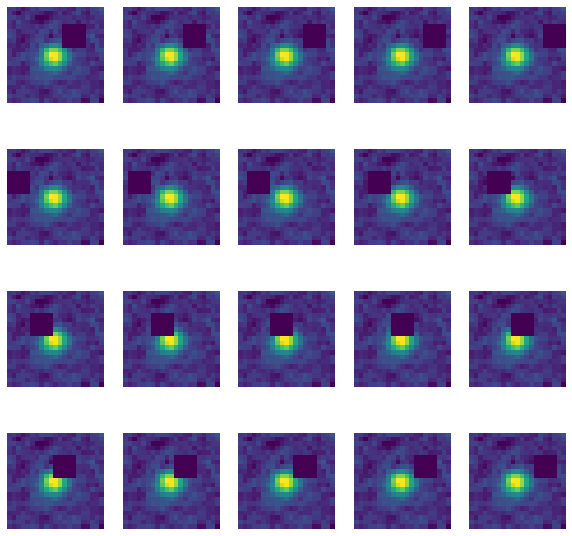

In [12]:
### testing out the occlusion generator class
x=preprocessar(x_train[3])

occ = OcclusionGenerator(x, 5, 1, False)
occList = []
%matplotlib inline 
plt.rcParams['figure.figsize'] = (10, 10)
for i in range(100):
    occList.append(occ.flow()[0])
for i in range(20):
    plt.subplot(4,5,i+1)
    plt.imshow(occList[i+80], cmap='viridis'); plt.axis("off")
plt.show()
#print(occList[i].shape)
del occ, x ,occList

In [13]:
# this function takes a list of heatmaps and merges them into one single heatmap
def post_process(heatmap):

    # postprocessing
    total = heatmap[0]
    for val in heatmap[1:]:
        total = total + val
    
    return total

In [14]:
#### This is the meat of the program. It generates the heatmap for the given image location ####

def gen_heatmap(fileloc, label, boxsize, step, verbose=True, savetodisk=False, batch=10, index=3):

    # load up image 

    img=preprocessar_2d(fileloc[index])
    if verbose:
        plt.imshow(img); plt.axis("off")
        plt.show()
    
    
    r_img= fileloc[index]
    
    # classify image (w/o occlusions)   

    model = load_model('super_nova_class.model')

    img_pred=to_4_axis(r_img)
    preds = model.predict(img_pred)
    correct_class_index = np.argmax(preds)

    # load correct label 

    correct_class_label = label[index]
    if verbose:
        print ('\n\n\ncorrect_class_label:', correct_class_label, '\n\n\n') 

    # generate occluded images and location of mask
    occ = OcclusionGenerator(img, boxsize, step, True)

    # scores of occluded image
    heatmap = []
    index = 0
    
    while True:

        # get minibatch of data
        x, locations = occ.gen_minibatch(batchsize=batch)

        if x is not None:

            #predict 
            op = model.predict(np.expand_dims(x, axis=-1))

            #unpack prediction values 
            for i in range(x.shape[0]):
                score = op[i][correct_class_index]
                r,c = locations[i] 
                scoremap = np.zeros((21,21))
                scoremap[r : r+occ.boxsize, c : c+occ.boxsize] = score
                heatmap.append(scoremap)

            if verbose:
                print ('..minibatch completed')
        else:
            break

    if savetodisk:
        #save heatmap to disk 
        
        f = open("heatmap", 'wb')
        pickle.dump(heatmap, f)
        f.close()

    return heatmap, correct_class_index, correct_class_label

(21, 21, 1)
----> (21, 21)


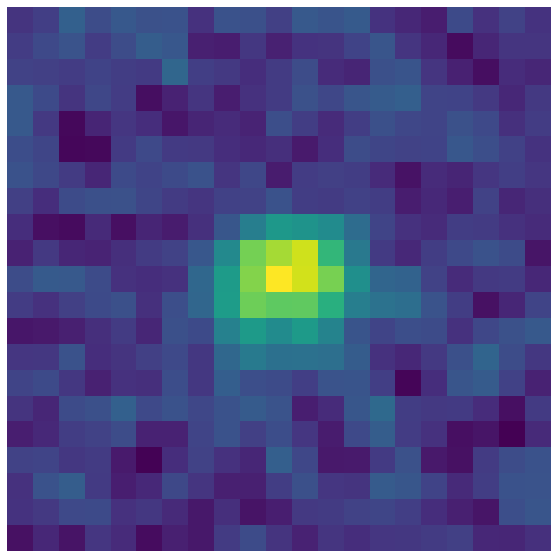






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



correct_class_label: 1 



..minibatch completed
..minibatch completed
..minibatch completed
..minibatch completed
..minibatch completed
..minibatch completed
..minibatch completed
..minibatch completed
..minibatch completed
..minibatch completed
..minibatch completed
..minibatch completed
..minibatch completed
..minibatch completed
..minibatch completed
..minibatch completed
..minibatch completed
..minibatch completed
..minibatch completed
..minibatch completed
..minibatch completed
..minibatch completed
..minibatch completed
..minibatch completed
..minibatch completed
..minibatch completed
..minibatch completed
..minibatch completed
..minibatch completed
..minibatch completed
..minibatch completed
..minibatch completed
..minibatch completed
..minibatch completed
..mini

In [15]:
# run the program on image
index_=95

heatmapList, index, label = gen_heatmap(r_x_train, y_train ,  3, 1, True, False, batch=10, index=index_)
processed   = post_process(heatmapList)
processed = normalize(processed)

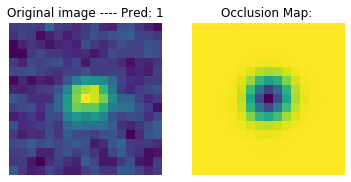

In [16]:
%matplotlib inline

img=x_train[index_]

plt.subplot(121)
plt.imshow(img[2:19, 2:19]); plt.axis("off")
plt.title("Original image ---- Pred: "+ str(label) )
plt.subplot(122)
plt.imshow(processed[2:19, 2:19])
plt.title("Occlusion Map: ")
plt.axis("off")

plt.show()

In [17]:
print('       ESTADISTICAS Processed      \n')
print('Valor máximo :', processed.max())
print('Valor mínimo :', processed.min())
print('Valor promedio :', processed.mean())
print('Valor varianza :', processed.var())
print('Valor desviación standar :', processed.std())

       ESTADISTICAS Processed      

Valor máximo : 0.8475424516992706
Valor mínimo : 0.0
Valor promedio : 0.5805350779927808
Valor varianza : 0.1263819131175113
Valor desviación standar : 0.355502339116793
